In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'D:\RH_local\github').resolve()

dir_analysisFiles = Path(r'D:\RH_local\data\round_6_experiments\mouse_1_19\scanimage_data\20220322\analysis_day0').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'D:\RH_local\data\round_6_experiments\mouse_1_19\scanimage_data\20220322\baseline\suite2p\plane0').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import *

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [6]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [7]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [8]:
dFoF_params = pickle_helpers.simple_load(path_tqm)['dFoF_params']

In [9]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [10]:
frame_height = ops[()]['meanImg'].shape[0]
frame_width = ops[()]['meanImg'].shape[1]

sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

In [11]:
sf.shape

(3369, 512, 1024)

In [12]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [13]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [14]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(F_toUse,
                                             kernel=kernel_smoothing,
                                             axis=1,mode='same',
                                             multicore_pref=True,
                                             verbose=True).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(F=F_smooth + channelOffset_correction,
                                                                 Fneu=Fneu_toUse + channelOffset_correction,
                                                                 neuropil_fraction=neuropil_fraction,
                                                                 percentile_baseline=percentile_baseline,
                                                                 multicore_pref=True,
                                                                 verbose=True)
# Threshold for nonnegativity
dFoF[dFoF<0]=0

ThreadPool elapsed time : 0.15 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.3 seconds
Calculated dFoF. Total elapsed time: 6.17 seconds


In [15]:
# Test out rolling subtraction of the 10th percentile of the data to remove microscope movement artifacts

ptile = 10
window = int(Fs*60*1)

dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_pd(dFoF, ptile=ptile, window=window)

# Run NMF

In [16]:
# indices_cropped = np.arange(int(Fs*60*23),dFoF_sub_ptile.shape[1])

In [17]:
# neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))[:,indices_cropped]
neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))

In [18]:
tl.set_backend('pytorch')

In [19]:
neural_data_toUse = tl.tensor(neural_data_toUse).to('cuda')

In [20]:
# Roll a dice and wish for luck
rank = 10

In [21]:
factors_nmf = tl.decomposition.non_negative_parafac(
            neural_data_toUse,
            rank=rank,
            n_iter_max=500,
            init='random',
            svd='numpy_svd', 
            tol=1e-06,
        #     random_state=None,
            verbose=0,
        #     normalize_factors=False,
        #     return_errors=False,
        #     mask=None,
        #     cvg_criterion='abs_rec_error',
        #     fixed_modes=None
        )

In [22]:
factors_temporal_nmf = np.array(factors_nmf.factors[1].to('cpu')).T

# Run Regression
Regress z-scored NMF temporal factors onto z-scored neural data itself

In [23]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])
## z-score NMF outputsneural_data_toUse 
factors_temporal_nmf_zscore = scipy.stats.zscore(factors_temporal_nmf[:,indices_to_use],axis=1)
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse.to('cpu')).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

100%|██████████████████████████████████████████████████████████████████████████| 90000/90000 [00:17<00:00, 5227.06it/s]
D:\RH_local\github\basic_neural_processing_modules\welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in sqrt
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)
D:\RH_local\github\basic_neural_processing_modules\welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in true_divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


In [24]:
# OLS Regression
theta, factors_temporal_regression = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_nmf_zscore.T)
factors_temporal_regression = factors_temporal_regression.T

In [25]:
# Filter based on Explained Variance
# If we can't predict a factor well, don't keep it
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T, factors_temporal_nmf_zscore.T)
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]
(pairwise > ev_threshold).sum()

10

In [26]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].cpu().numpy().T, factors_temporal_tokeep,  np.ones(rank, bool))

<IPython.core.display.Javascript object>


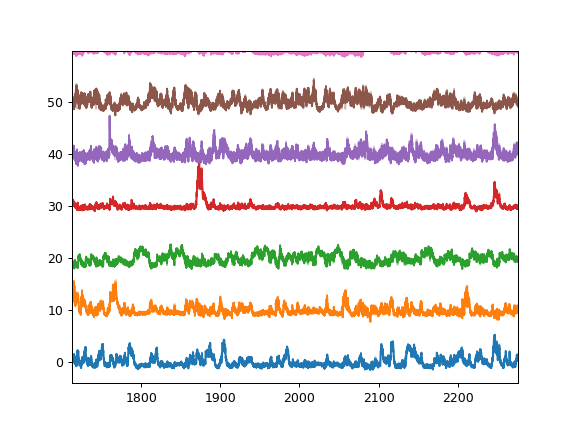

In [29]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_nmf_zscore[np.argsort(evrs)[::-1],:].T + 10*np.arange(10),alpha=0.4)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(10))

<IPython.core.display.Javascript object>


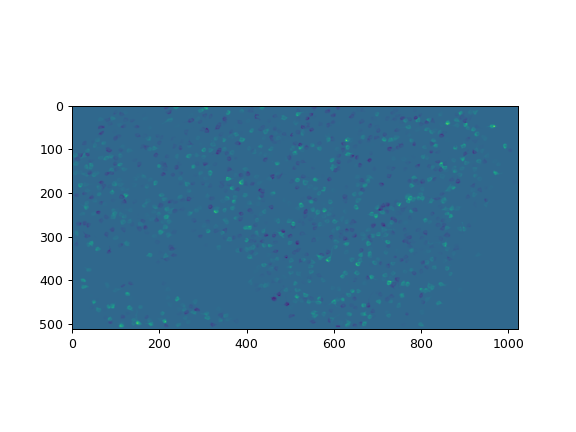

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [28]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(sf_weights)

# Run Orthogonalization

In [30]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
num_factors = rank
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

Factor at 2 index explains 0.04002940654754639 of the variance in neural data
Factor at 3 index explains 0.01905381679534912 of the variance in neural data
Factor at 0 index explains 0.015409469604492188 of the variance in neural data
Factor at 4 index explains 0.01458197832107544 of the variance in neural data
Factor at 8 index explains 0.014362871646881104 of the variance in neural data
Factor at 6 index explains 0.010679066181182861 of the variance in neural data
Factor at 5 index explains 0.011281609535217285 of the variance in neural data
Factor at 9 index explains 0.0115012526512146 of the variance in neural data
Factor at 1 index explains 0.004132390022277832 of the variance in neural data


<IPython.core.display.Javascript object>


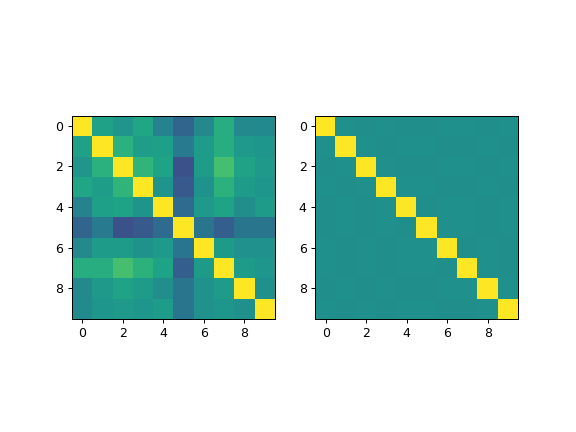

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)

In [32]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth,  np.ones(num_factors, bool))

In [33]:
evrs

array([0.01540947, 0.00413239, 0.04002941, 0.01905382, 0.01458198,
       0.01128161, 0.01067907, 0.00344098, 0.01436287, 0.01150125])

# Run Regression Pt 2

In [34]:
# OLS Regression
theta, factors_orth_regression = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

In [35]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].cpu().numpy().T, factors_orth,  np.ones(num_factors, bool))

<IPython.core.display.Javascript object>


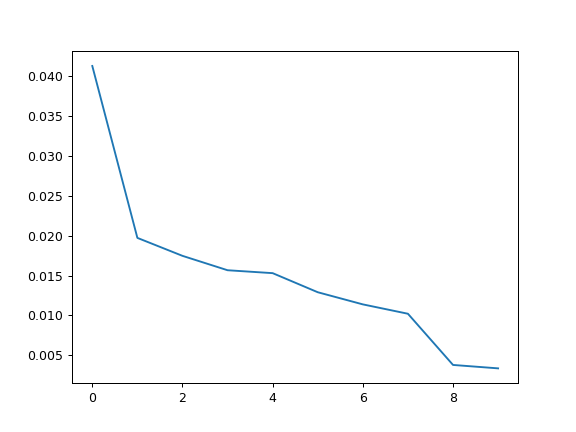

In [36]:
plt.figure()
plt.plot(np.sort(evrs)[::-1])

# Visualize

<IPython.core.display.Javascript object>


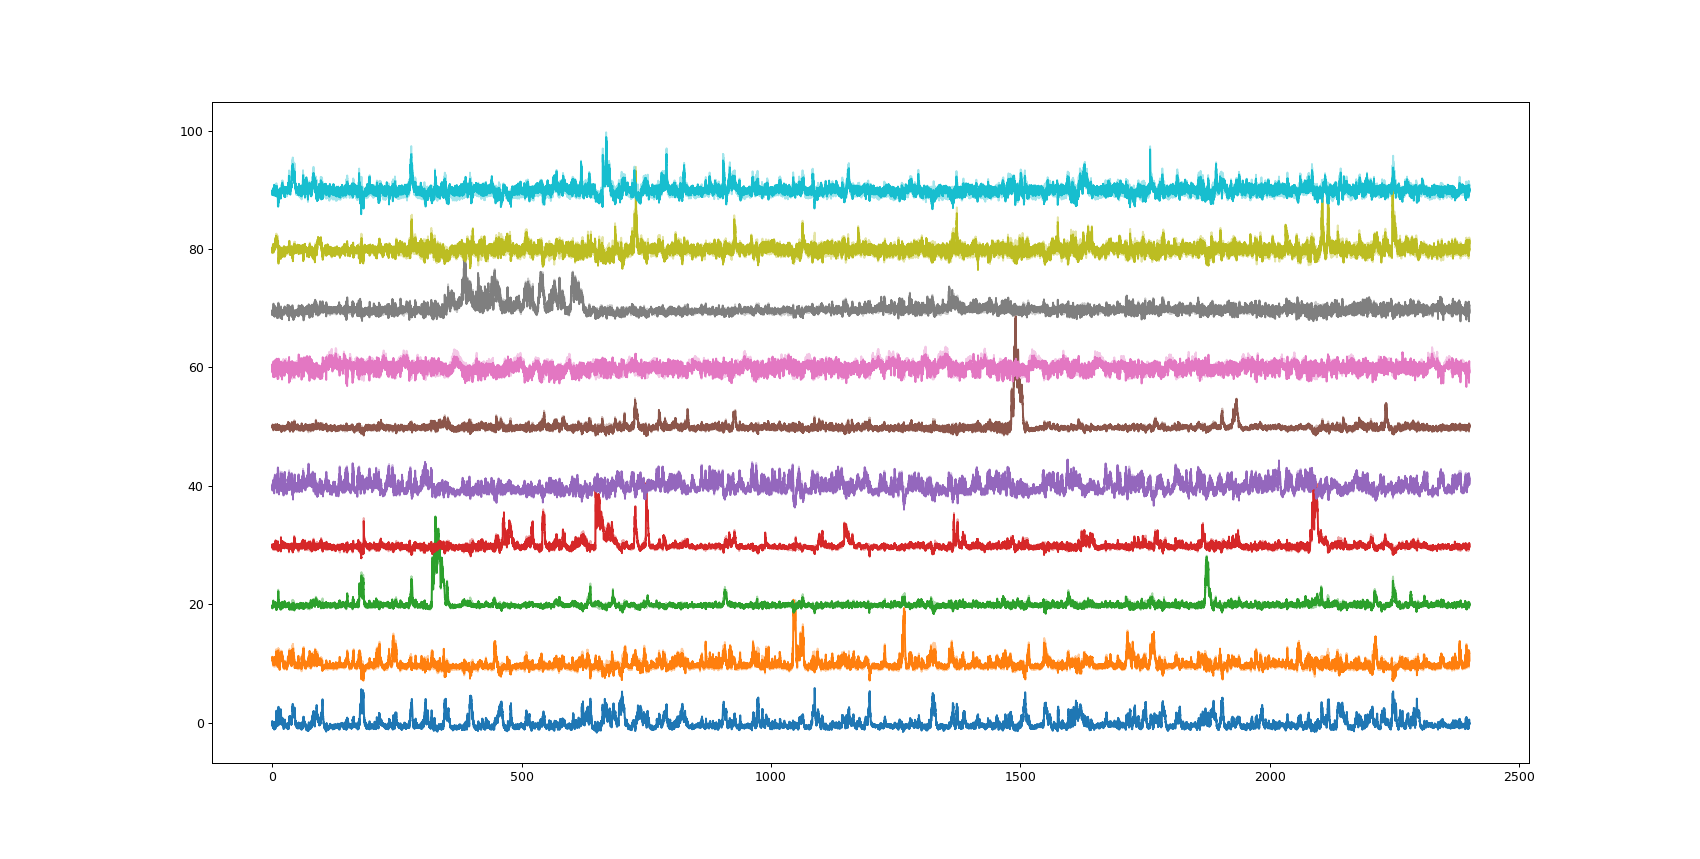

In [47]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(10),alpha=0.4)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(10))

<IPython.core.display.Javascript object>


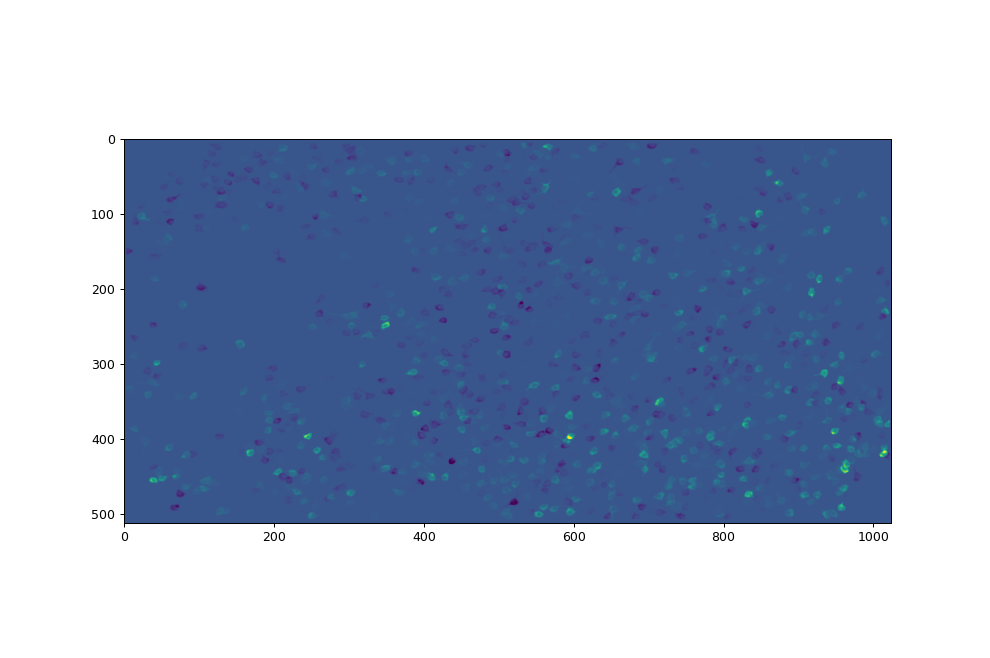

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [331]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(sf_weights)

<IPython.core.display.Javascript object>


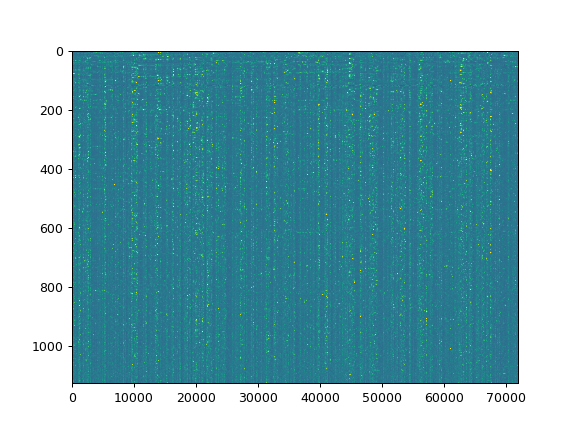

In [39]:
plt.figure()
plt.imshow(neural_data_toUse_zscore, aspect='auto', vmax=4)

<IPython.core.display.Javascript object>


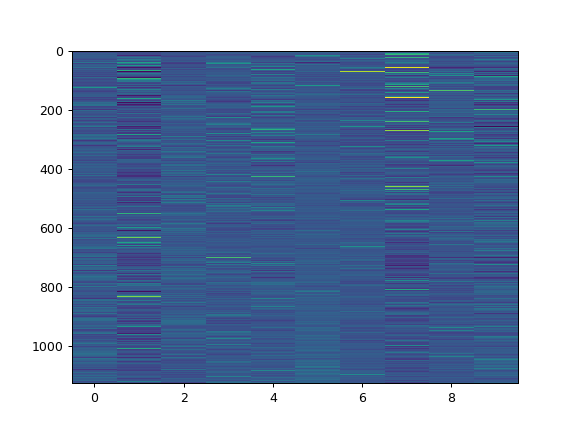

In [40]:
%matplotlib notebook
plt.figure()
plt.imshow(theta[:,:],aspect='auto', interpolation='none')

# Save it all

In [41]:
factor_to_use = 0
weights = theta[:,np.argsort(evrs)[::-1]]

weights_day0 = {
    "weights": weights[:,factor_to_use],
    "weights_all" : weights,
    "iscell_custom": iscell,
    "factor_to_use": factor_to_use
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

<IPython.core.display.Javascript object>


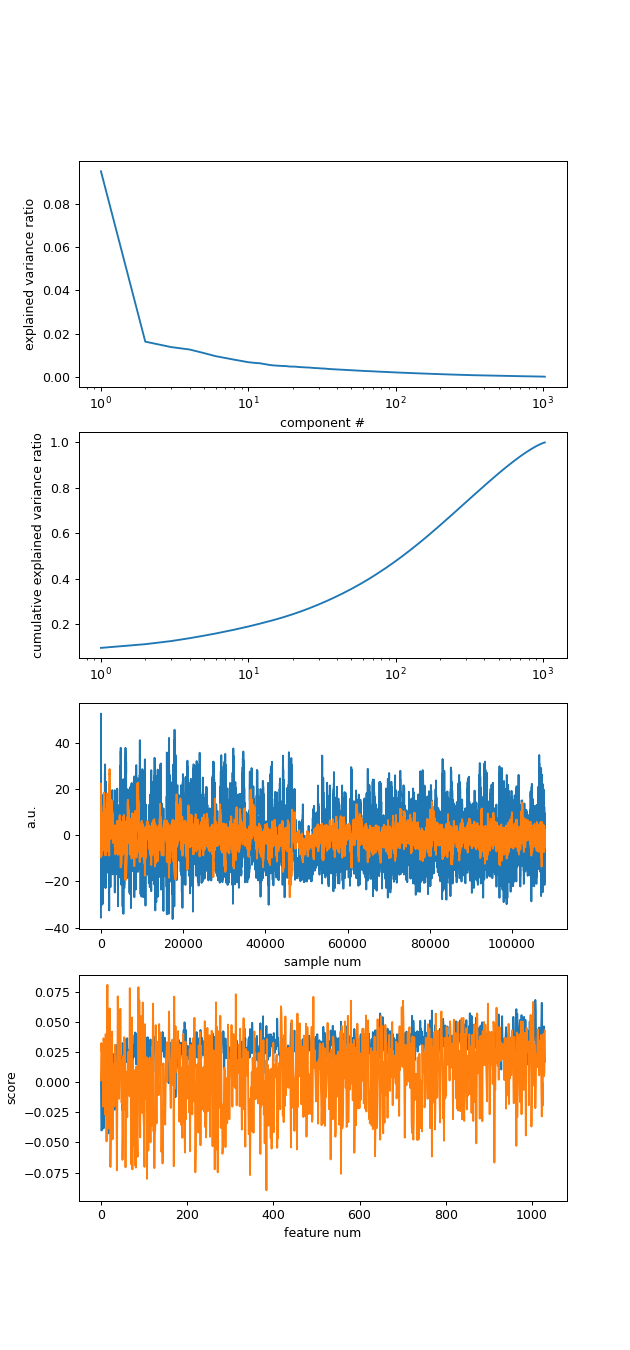

In [341]:
components , scores , explained_variance_ratio_ , stds = decomposition.simple_pca(neural_data_toUse.T.cpu().numpy() , n_components=None , mean_sub=True, zscore=False, plot_pref=True , n_PCs_toPlot=2)

In [347]:
factors_orth_regression.shape

(10, 90000)

<IPython.core.display.Javascript object>


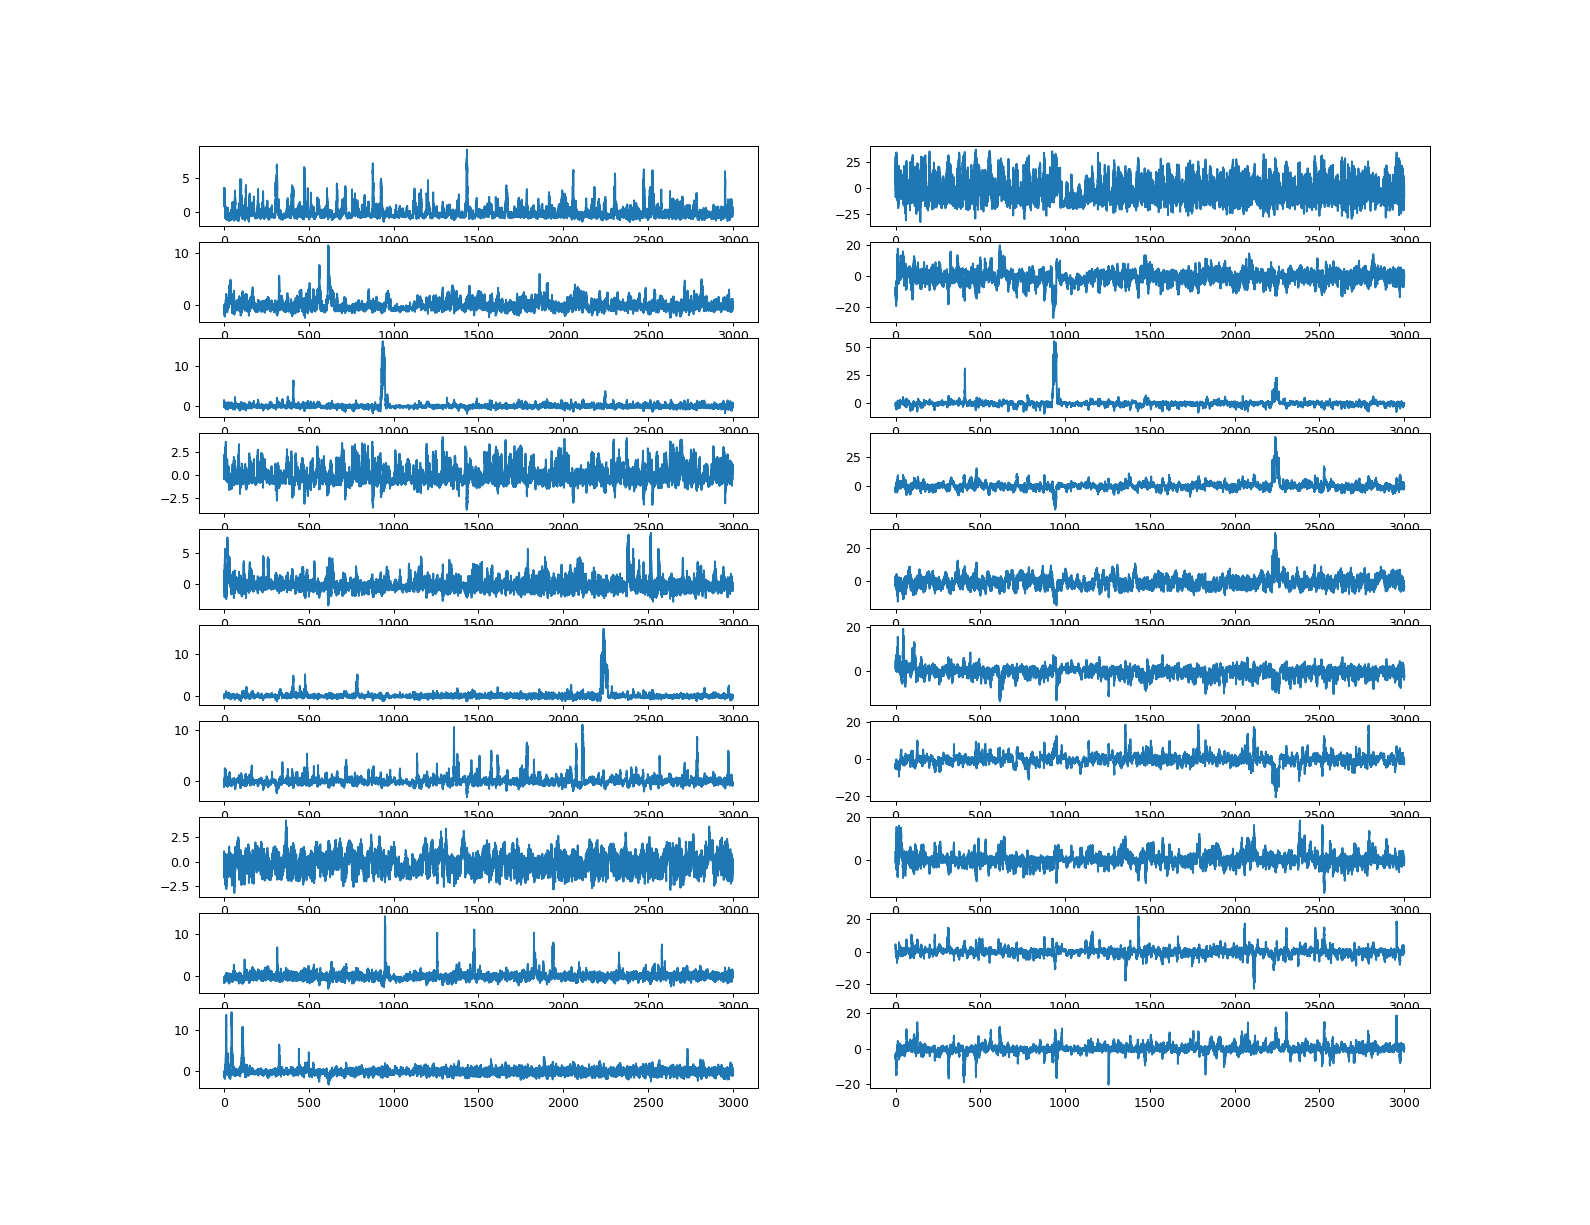

In [352]:
%matplotlib notebook
fig, axs = plt.subplots(factors_orth_regression.shape[0], 2, sharex='row')
for ii in range(axs.shape[0]):
    axs[ii,0].plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii,1].plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, scores[:,ii][indices_to_use])

In [42]:
import rastermap

In [43]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
#     nPC=200,
#     init='pca',
#     alpha=1.0,
#     K=1.0,
#     mode='basic',
#     verbose=True,
#     annealing=True,
#     constraints=2,
)

In [44]:
# embedding = rmap.fit_transform(neural_data_toUse.cpu().numpy())
# embedding = rmap.fit_transform(dFoF)
embedding = rmap.fit_transform(np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression]))

nmin 200
0.10871005058288574
2.9071884155273438
3.0128836631774902
3.0138816833496094
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.23s     0        0.0981      2
0.27s    10        0.1340      4
0.30s    20        0.1664      8
0.33s    30        0.2173      18
0.36s    40        0.2495      28
0.39s    50        0.2762      38
0.43s    60        0.2787      38
0.46s   final      0.2787
0.46s upsampled    0.2787


<IPython.core.display.Javascript object>


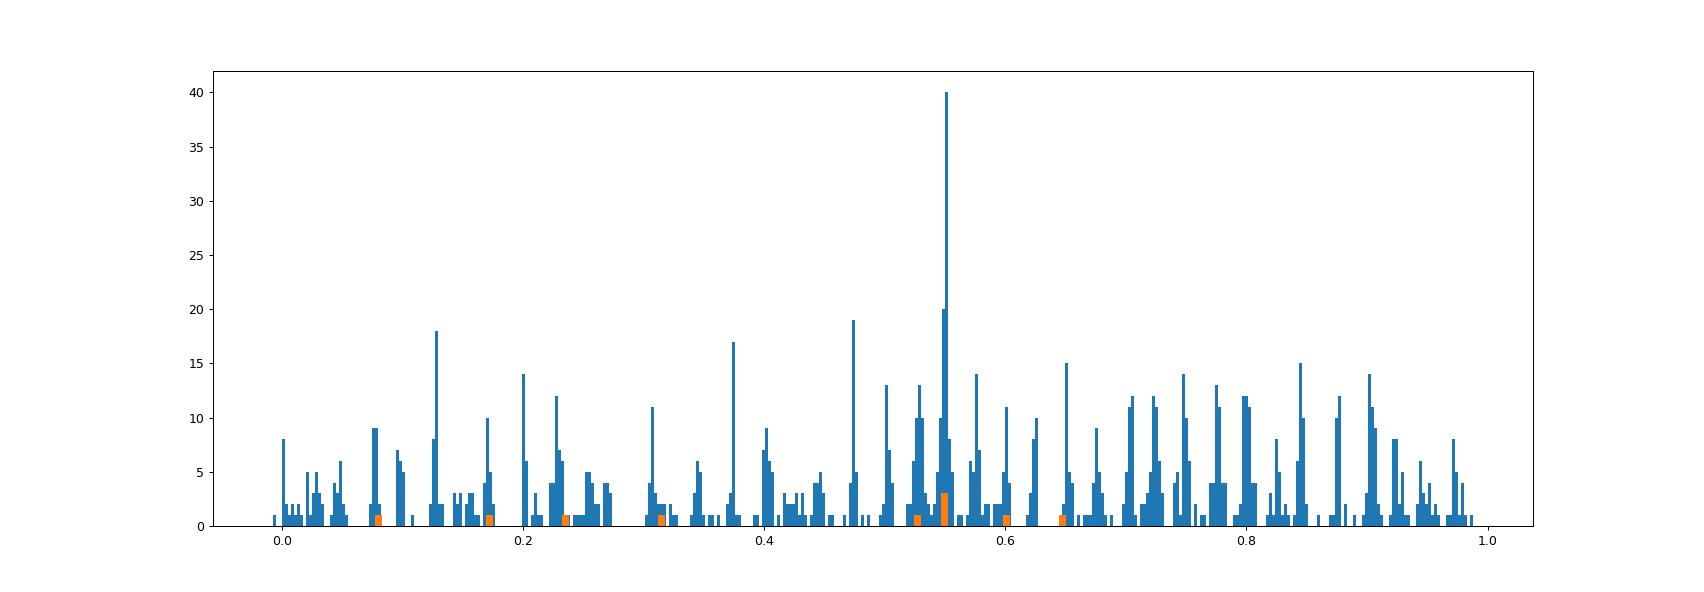

In [45]:
plt.figure()
plt.hist(embedding, 400);
plt.hist(embedding[-10:], 100);

<IPython.core.display.Javascript object>


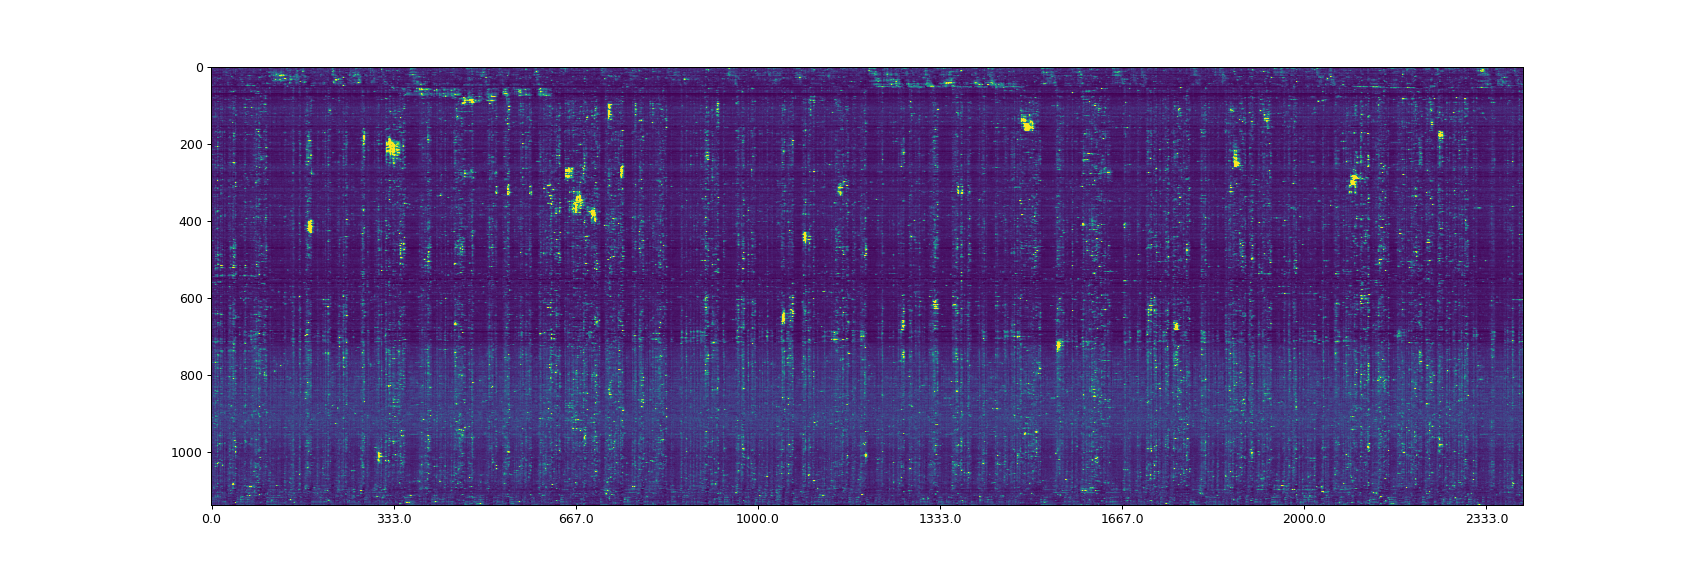

([<matplotlib.axis.XTick at 0x1ebc0a4e250>,
 [Text(0, 0, '0.0'),
  Text(10000, 0, '333.0'),
  Text(20000, 0, '667.0'),
  Text(30000, 0, '1000.0'),
  Text(40000, 0, '1333.0'),
  Text(50000, 0, '1667.0'),
  Text(60000, 0, '2000.0'),
  Text(70000, 0, '2333.0')])

In [46]:
plt.figure()
plt.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
plt.xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))

<IPython.core.display.Javascript object>


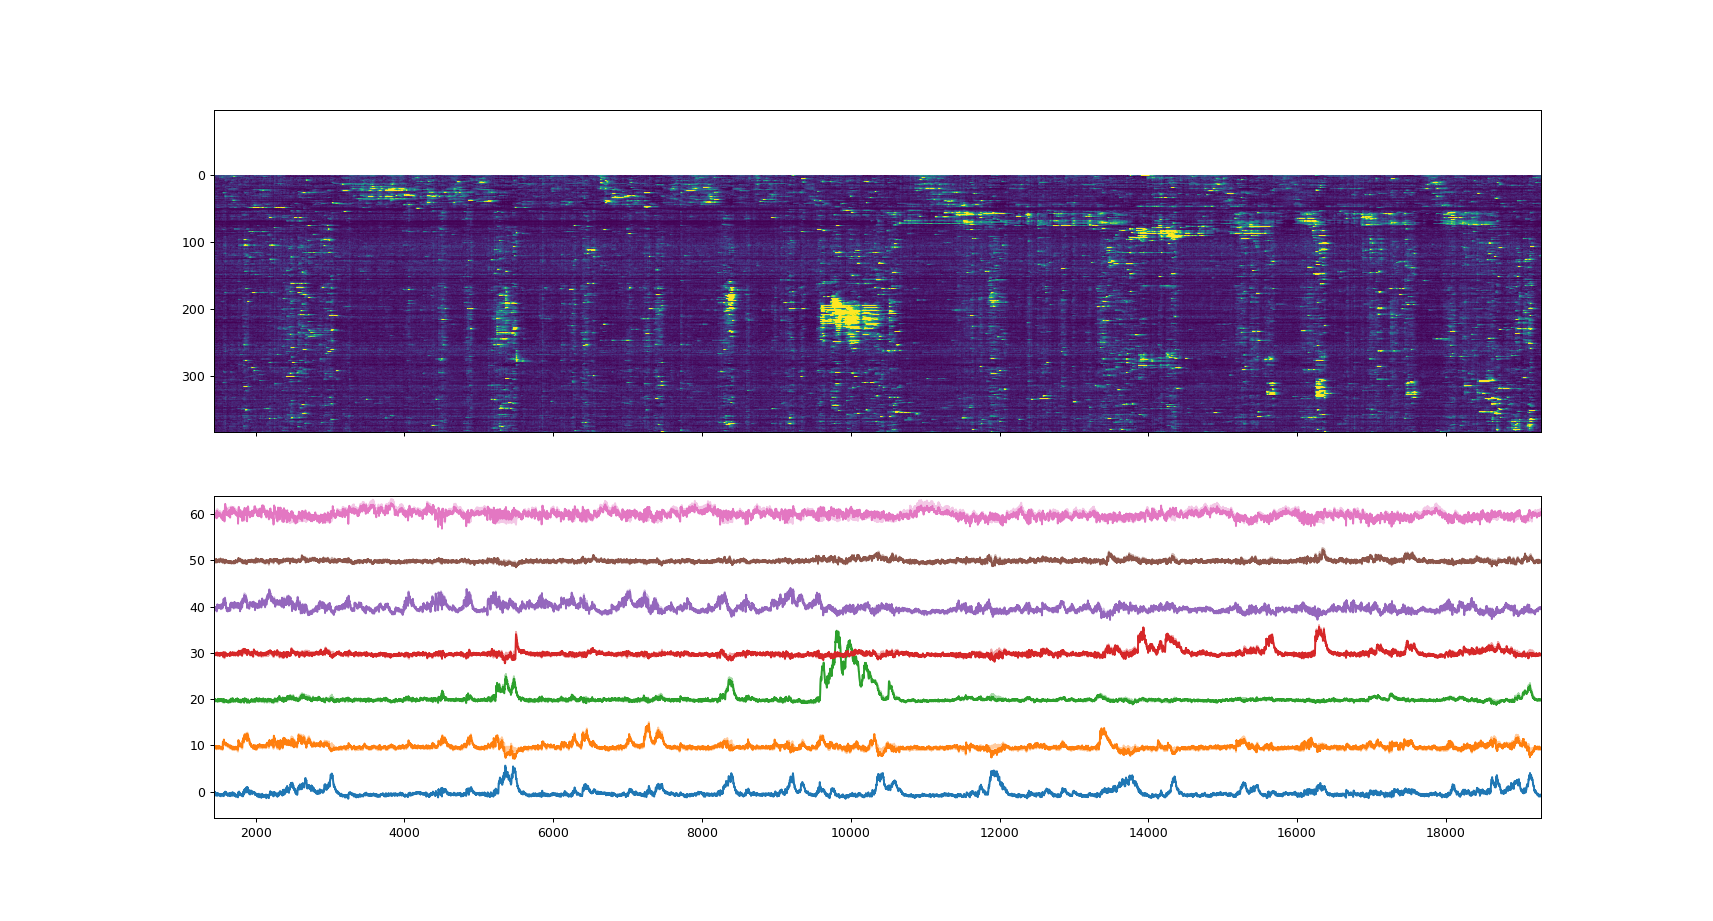

In [53]:
f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
#ax1.set_xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))
ax2.plot(factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(10),alpha=0.4)
ax2.plot(factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(10))

In [359]:
indices_to_use.shape

(90000,)